In [55]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow import keras
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpu = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu, True)
%config InlineBackend.figure_format = 'retina'

Num GPUs Available:  1


In [56]:
data = pd.read_csv("data/item1213.csv", index_col=0).iloc[:, 1:]
data.columns = ['m0', 'qty1', 'qty2', 'qty3']
data.tail()

,m0,qty1,qty2,qty3
period_id,,,,
1255,0.2405,0.2207,0.0608,0.0
1256,0.4851,0.4583,0.0057,0.0
1257,0.0948,0.0523,0.0523,0.0
1258,0.1740,0.1386,0.0156,0.0
1259,0.1174,0.1174,0.0000,0.0


## Forecast a multivariate time series

               m0    qty1    qty2  qty3
period_id                              
1213       0.2447  0.1952  0.0000   0.0
1214       0.1980  0.0905  0.1132   0.0
1215       0.5205  0.3918  0.0184   0.0
1216       0.1627  0.1174  0.0000   0.0
1217       0.2037  0.1132  0.0000   0.0


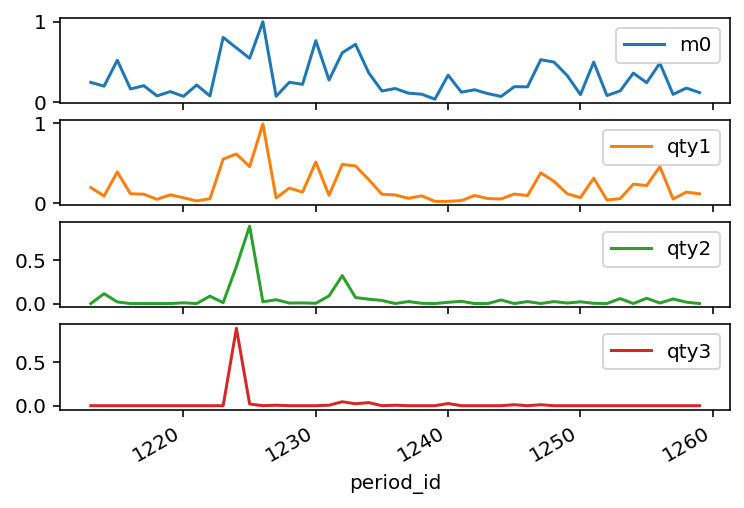

In [90]:
features_considered = ['m0', 'qty1', 'qty2', 'qty3']
features = data[features_considered]
features.index = data.index
print(features.head())
features.plot(subplots=True)
plt.show()

### Standardization

In [91]:
dataset = tf.keras.utils.normalize(features.values)

### Single step model

In a single step setup, the model learns to predict a single point in the future based on some history provided.

The below function performs the same windowing task as below, however, here it samples the past observation based on the step size given.

In [92]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    if end_index is None:
        end_index = len(dataset) - target_size
    else:
        start_index = start_index + history_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [142]:
TRAIN_SPLIT = 38
past_history = 5
future_target = 0
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 0], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 0],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [143]:
print('Shape of x_train window')
print(x_train_single.shape)
print('\n Single window of past history')
print(x_train_single[0])
print('\n Target temperature to predict')
print(y_train_single)

Shape of x_train window
(33, 5, 4)

 Single window of past history
[[0.78174074 0.62360357 0.         0.        ]
 [0.80693086 0.36882446 0.46133623 0.        ]
 [0.79863039 0.60115925 0.02823208 0.        ]
 [0.81092887 0.58514474 0.         0.        ]
 [0.87409655 0.48575223 0.         0.        ]]

 Target temperature to predict
[0.84625134 0.77905449 0.71854826 0.99122382 0.60226581 0.82414297
 0.50190062 0.47790574 0.70905501 0.66842741 0.7921913  0.84653972
 0.82895034 0.90200275 0.72408668 0.83554548 0.76938322 0.76041848
 0.85191147 0.86199527 0.72788793 0.84287626 0.99400315 0.9480426
 0.84625134 0.87474777 0.72176615 0.856272   0.88928873 0.81095396
 0.87511215 0.94190111 0.78687563]


In [144]:
tf.random.set_seed(13)
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [145]:
single_step_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]),
    tf.keras.layers.Dense(1)
])
single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [146]:
EVALUATION_INTERVAL = 500
EPOCHS = 10

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 500 steps, validate for 50 steps
Epoch 1/10
500/500 [==============================] - 2s 5ms/step - loss: 0.0886 - val_loss: 0.0515
Epoch 2/10
500/500 [==============================] - 1s 3ms/step - loss: 0.0651 - val_loss: 0.0664
Epoch 3/10
500/500 [==============================] - 1s 3ms/step - loss: 0.0625 - val_loss: 0.0613
Epoch 4/10
500/500 [==============================] - 1s 3ms/step - loss: 0.0592 - val_loss: 0.0734
Epoch 5/10
500/500 [==============================] - 1s 3ms/step - loss: 0.0498 - val_loss: 0.0748
Epoch 6/10
500/500 [==============================] - 1s 3ms/step - loss: 0.0376 - val_loss: 0.0929
Epoch 7/10
500/500 [==============================] - 1s 3ms/step - loss: 0.0315 - val_loss: 0.1052
Epoch 8/10
500/500 [==============================] - 1s 3ms/step - loss: 0.0274 - val_loss: 0.1092
Epoch 9/10
500/500 [==============================] - 1s 3ms/step - loss: 0.0243 - val_loss: 0.1129
Epoch 10/10
500/500 [==============================] - 1s

In [147]:
def plot_train_history(history, title):
    loss = history.history['loss']
#     val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
#     plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

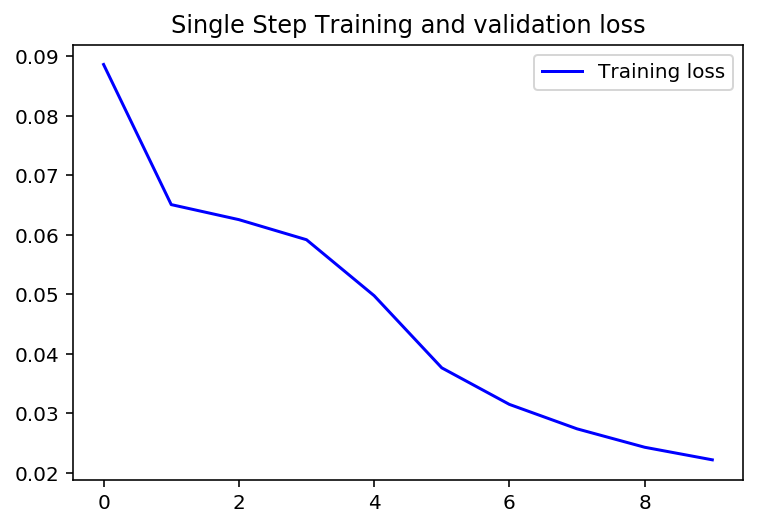

In [148]:
plot_train_history(single_step_history, 'Single Step Training and validation loss')

In [149]:
mse_test = single_step_model.evaluate(x_val_single, y_val_single)

9/9 [==============================] - 0s 19ms/sample - loss: 0.1054


In [150]:
y_pred_train = single_step_model.predict(x_train_single)
y_pred_val = single_step_model.predict(x_val_single)

In [151]:
y_pred_val

array([[0.867926 ],
       [0.7860965],
       [0.7449367],
       [0.8763597],
       [0.9184524],
       [0.8599723],
       [0.8642501],
       [0.6319641],
       [0.6073135]], dtype=float32)

In [152]:
y_val_single

array([0.84583439, 0.8975234 , 0.86596117, 0.83361142, 0.72432735,
       0.72687443, 0.78842418, 0.78026655, 0.70710678])

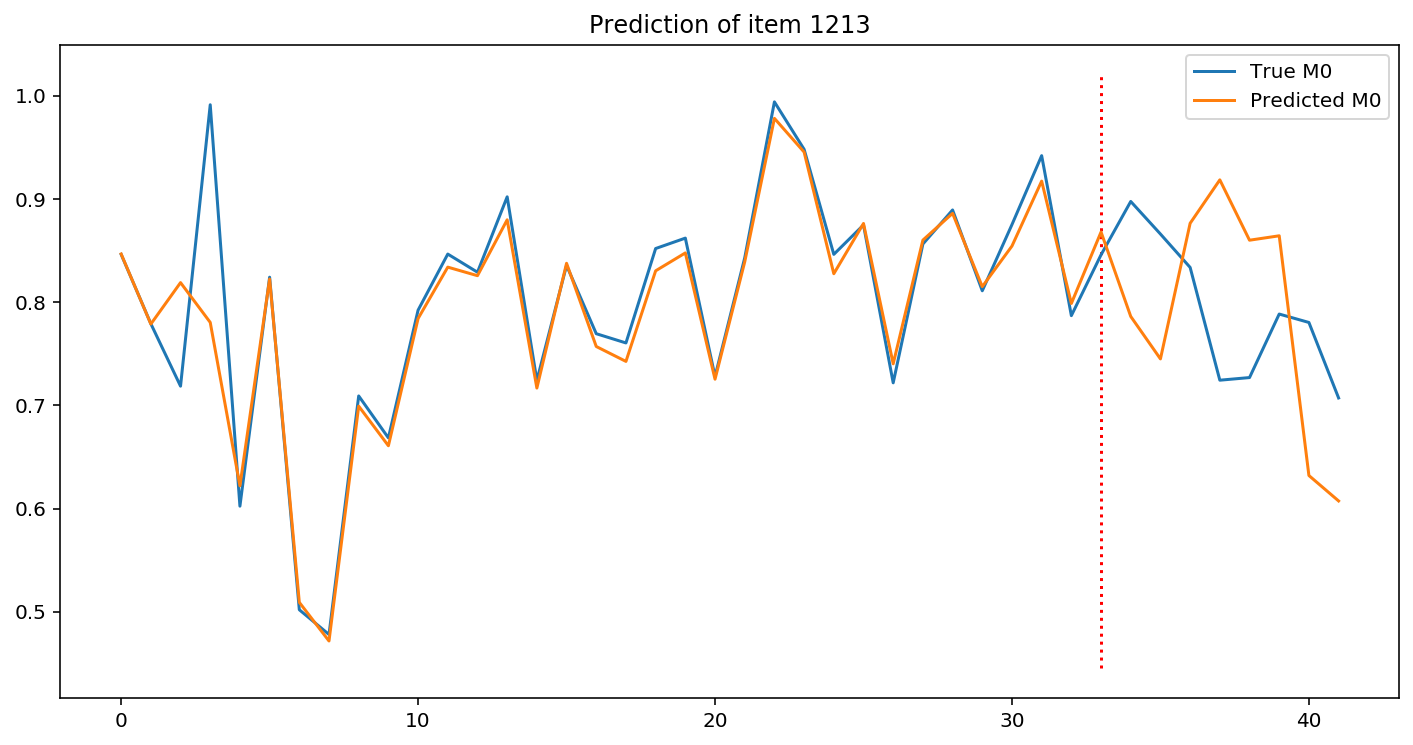

In [153]:
plt.figure(figsize=(12, 6))
plt.plot(np.append(y_train_single, y_val_single), label='True M0')
plt.plot(np.append(y_pred_train, y_pred_val), label='Predicted M0')
ax = plt.gca()
ymin, ymax = ax.get_ylim()
plt.vlines(len(y_train_single), ymin, ymax, linestyles="dotted", color='r')
plt.legend()
plt.title("Prediction of item 1213")
plt.show()